
Sistema de Recomendação de Produtos Agrícolas do DF
Projeto 1 - Introdução à Inteligência Artificial
Professor Díbio - UnB 2025/1

Raul Myron Silva Amorim - 200049712
Lucca Santos Aguilar - 241024221
Thais Aragão Bianchini - 

Este notebook implementa um sistema de recomendação para
pequenos produtores rurais a consumidores no Distrito Federal.


In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
import folium
from datetime import datetime
import random
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [29]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

print("=" * 60)
print("SISTEMA DE RECOMENDAÇÃO DE PRODUTOS AGRÍCOLAS DO DF")
print("Projeto 1 - Introdução à Inteligência Artificial")
print("=" * 60)

SISTEMA DE RECOMENDAÇÃO DE PRODUTOS AGRÍCOLAS DO DF
Projeto 1 - Introdução à Inteligência Artificial


In [33]:
''' LEITURA DAS TABELAS '''

try:
    df_associacoes = pd.read_csv('tabelas/associacoes.csv')
    df_dados_nutricionais = pd.read_csv('tabelas/dados_nutricionais.csv')
    df_producao_emater = pd.read_csv('tabelas/producao_emater.csv')
    df_mapeamento = pd.read_csv('tabelas/mapeamento_produtos.csv')
    df_produtos_escopo = pd.read_csv('tabelas/produtos_escopo.csv')

    print(f"   TUDO FOI LIDO!")
    print()
    print(f"   Resumo dos dados:")
    print(f"   Associações: {len(df_associacoes)} registros")
    print(f"   Dados nutricionais: {len(df_dados_nutricionais)} produtos")
    print(f"   Produção EMATER: {len(df_producao_emater)} registros")
    print(f"   Mapeamento produtos: {len(df_mapeamento)} mapeamentos")
    print(f"   Produtos escopo: {len(df_produtos_escopo)} produtos")
    
except FileNotFoundError as e:
    print(f"❌ Erro ao carregar arquivo: {e}")
    print("Certifique-se de que todos os arquivos CSV estão na pasta 'tabelas/'")

   TUDO FOI LIDO!

   Resumo dos dados:
   Associações: 17 registros
   Dados nutricionais: 35 produtos
   Produção EMATER: 105 registros
   Mapeamento produtos: 25 mapeamentos
   Produtos escopo: 35 produtos


In [37]:
print("\n🔍 ANÁLISE EXPLORATÓRIA DOS DADOS")
print("-" * 50)

# Análise das Associações
print(" Associações/Cooperativas:")
print(f"   Total: {len(df_associacoes)}")
print(f"   Regiões únicas: {df_associacoes['regioes'].str.split(',').explode().nunique()}")

# Análise dos Dados Nutricionais
print(f"\n Dados Nutricionais:")
print(f"   Produtos com dados: {len(df_dados_nutricionais)}")
print(f"   Categorias: {df_dados_nutricionais['categoria'].nunique()}")
print(f"   Energia média: {df_dados_nutricionais['energia_kcal'].mean():.1f} kcal")
print(f"   Vitamina C média: {df_dados_nutricionais['vitamina_c_mg'].mean():.1f} mg")

# Top 5 produtos por vitamina C
print(f"\n Top 5 produtos por Vitamina C:")
top_vit_c = df_dados_nutricionais.nlargest(5, 'vitamina_c_mg')[['nome', 'vitamina_c_mg', 'categoria']]
for _, row in top_vit_c.iterrows():
    print(f"   {row['nome']}: {row['vitamina_c_mg']}mg ({row['categoria']})")

# Análise da Produção EMATER
print(f"\n🚜 Produção EMATER-DF:")
print(f"   Registros: {len(df_producao_emater)}")
print(f"   Regiões: {df_producao_emater['regiao'].nunique()}")
print(f"   Produtos: {df_producao_emater['produto'].nunique()}")
print(f"   Área total: {df_producao_emater['area_ha'].sum():.1f} hectares")
print(f"   Produção total: {df_producao_emater['producao_t'].sum():.1f} toneladas")


🔍 ANÁLISE EXPLORATÓRIA DOS DADOS
--------------------------------------------------
 Associações/Cooperativas:
   Total: 17
   Regiões únicas: 35

 Dados Nutricionais:
   Produtos com dados: 35
   Categorias: 12
   Energia média: 57.1 kcal
   Vitamina C média: 20.3 mg

 Top 5 produtos por Vitamina C:
   Lichia: 72mg (frutas_doces)
   Mamão: 62mg (frutas_doces)
   Limão: 53mg (frutas_acidas)
   Manga: 43mg (frutas_doces)
   Atemóia: 36mg (frutas_doces)

🚜 Produção EMATER-DF:
   Registros: 105
   Regiões: 7
   Produtos: 23
   Área total: 1295.9 hectares
   Produção total: 1144.5 toneladas


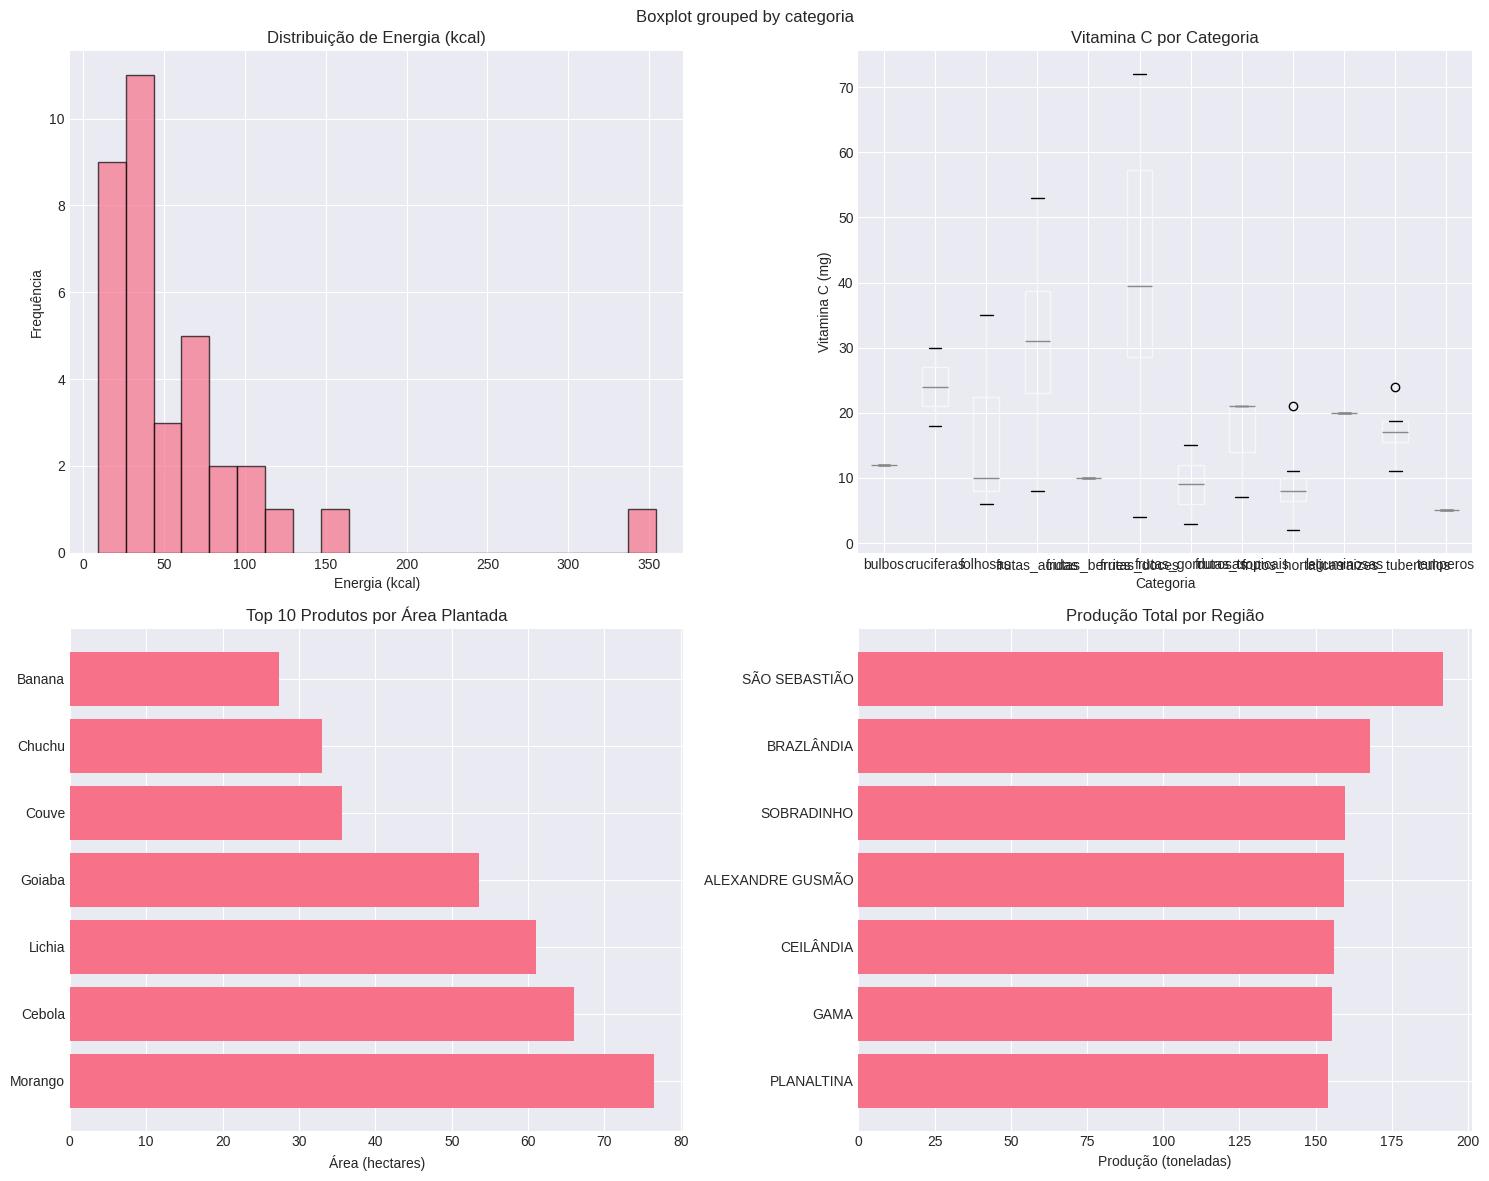

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribuição de calorias por categoria
axes[0,0].hist(df_dados_nutricionais['energia_kcal'], bins=20, edgecolor='black', alpha=0.7)
axes[0,0].set_title('Distribuição de Energia (kcal)')
axes[0,0].set_xlabel('Energia (kcal)')
axes[0,0].set_ylabel('Frequência')

# Vitamina C por categoria
df_dados_nutricionais.boxplot(column='vitamina_c_mg', by='categoria', ax=axes[0,1])
axes[0,1].set_title('Vitamina C por Categoria')
axes[0,1].set_xlabel('Categoria')
axes[0,1].set_ylabel('Vitamina C (mg)')

# Top 10 produtos por área (EMATER)
top_area = df_producao_emater.nlargest(10, 'area_ha')
axes[1,0].barh(top_area['produto'], top_area['area_ha'])
axes[1,0].set_title('Top 10 Produtos por Área Plantada')
axes[1,0].set_xlabel('Área (hectares)')

# Produção por região
prod_regiao = df_producao_emater.groupby('regiao')['producao_t'].sum().sort_values(ascending=True)
axes[1,1].barh(prod_regiao.index, prod_regiao.values)
axes[1,1].set_title('Produção Total por Região')
axes[1,1].set_xlabel('Produção (toneladas)')

plt.tight_layout()
plt.show()

In [39]:
print("\n⚙️ PREPARAÇÃO DOS DADOS PARA RECOMENDAÇÃO")
print("-" * 50)

# Criar lista de produtos únicos do escopo
produtos_escopo = df_produtos_escopo['produto'].tolist()
print(f"Produtos no escopo: {len(produtos_escopo)}")

# Processar produtos das associações
def processar_produtos_associacao(produtos_str, mapeamento_dict):
    """Processa string de produtos e aplica mapeamento"""
    if pd.isna(produtos_str):
        return []
    
    produtos_lista = [p.strip() for p in produtos_str.split(',')]
    produtos_mapeados = []
    
    for produto in produtos_lista:
        if produto in mapeamento_dict:
            produto_mapeado = mapeamento_dict[produto]
        else:
            produto_mapeado = produto
            
        if produto_mapeado in produtos_escopo and produto_mapeado not in produtos_mapeados:
            produtos_mapeados.append(produto_mapeado)
    
    return produtos_mapeados

# Criar dicionário de mapeamento
mapeamento_dict = dict(zip(df_mapeamento['produto_original'], df_mapeamento['produto_escopo']))
print(f"Mapeamentos disponíveis: {len(mapeamento_dict)}")

# Aplicar mapeamento nas associações
df_associacoes['produtos_limpos'] = df_associacoes['produtos'].apply(
    lambda x: processar_produtos_associacao(x, mapeamento_dict)
)

# Verificar resultados
total_produtos_assoc = sum(len(produtos) for produtos in df_associacoes['produtos_limpos'])
print(f"Total de produtos após mapeamento: {total_produtos_assoc}")


⚙️ PREPARAÇÃO DOS DADOS PARA RECOMENDAÇÃO
--------------------------------------------------
Produtos no escopo: 35
Mapeamentos disponíveis: 25
Total de produtos após mapeamento: 0


In [42]:
print("\n CRIAÇÃO DA MATRIZ DE UTILIDADE EXPANDIDA")
print("-" * 50)

def criar_matriz_expandida():
    """Cria matriz de utilidade com mais de 5000 linhas"""
    
    # Definir tipos de consumidores baseados nas regiões do DF
    tipos_consumidor = [
        {
            'tipo': 'Família Plano Piloto',
            'peso': 0.12,
            'produtos_preferidos': ['Alface', 'Tomate', 'Brócolis', 'Morango', 'Banana'],
            'poder_compra': 'alto',
            'prioridade_organico': 0.7
        },
        {
            'tipo': 'Família Taguatinga',
            'peso': 0.15,
            'produtos_preferidos': ['Batata', 'Cebola', 'Tomate', 'Repolho', 'Mandioca'],
            'poder_compra': 'médio',
            'prioridade_organico': 0.3
        },
        {
            'tipo': 'Família Ceilândia',
            'peso': 0.14,
            'produtos_preferidos': ['Batata', 'Mandioca', 'Abóbora', 'Banana', 'Cebola'],
            'poder_compra': 'baixo',
            'prioridade_organico': 0.2
        },
        {
            'tipo': 'Família Gama',
            'peso': 0.10,
            'produtos_preferidos': ['Tomate', 'Alface', 'Banana', 'Goiaba', 'Limão'],
            'poder_compra': 'médio',
            'prioridade_organico': 0.4
        },
        {
            'tipo': 'Restaurante',
            'peso': 0.08,
            'produtos_preferidos': ['Tomate', 'Cebola', 'Alface', 'Pimentão', 'Cenoura'],
            'poder_compra': 'alto',
            'prioridade_organico': 0.5
        },
        {
            'tipo': 'Escola/Creche',
            'peso': 0.06,
            'produtos_preferidos': ['Banana', 'Maracujá', 'Cenoura', 'Abóbora', 'Mamão'],
            'poder_compra': 'médio',
            'prioridade_organico': 0.6
        },
        {
            'tipo': 'Mercadores Locais',
            'peso': 0.08,
            'produtos_preferidos': produtos_escopo[:15],
            'poder_compra': 'alto',
            'prioridade_organico': 0.3
        },
        {
            'tipo': 'Consumidores Orgânicos',
            'peso': 0.07,
            'produtos_preferidos': ['Couve', 'Brócolis', 'Beterraba', 'Agrião', 'Morango'],
            'poder_compra': 'alto',
            'prioridade_organico': 0.9
        },
        {
            'tipo': 'Jovens Profissionais',
            'peso': 0.09,
            'produtos_preferidos': ['Banana', 'Morango', 'Tomate', 'Pepino', 'Alface'],
            'poder_compra': 'médio',
            'prioridade_organico': 0.4
        },
        {
            'tipo': 'Família Alternativa',
            'peso': 0.06,
            'produtos_preferidos': ['Chuchu', 'Abóbora', 'Goiaba', 'Mamão', 'Beterraba'],
            'poder_compra': 'baixo',
            'prioridade_organico': 0.3
        },
        {
            'tipo': 'Outros',
            'peso': 0.05,
            'produtos_preferidos': produtos_escopo[::3],
            'poder_compra': 'médio',
            'prioridade_organico': 0.4
        }
    ]
    
    print(f"Gerando usuários baseados em {len(tipos_consumidor)} tipos de consumidor...")
    
    # Gerar 5500 usuários para garantir 5000+ interações
    usuarios = []
    interacoes = []
    
    for user_id in range(1, 5501):
        # Escolher tipo de consumidor
        tipo_escolhido = np.random.choice(
            [t['tipo'] for t in tipos_consumidor],
            p=[t['peso'] for t in tipos_consumidor]
        )
        
        tipo_info = next(t for t in tipos_consumidor if t['tipo'] == tipo_escolhido)
        
        # Criar usuário
        usuario = {
            'user_id': f'USER_{user_id:05d}',
            'tipo': tipo_escolhido,
            'poder_compra': tipo_info['poder_compra'],
            'prioridade_organico': tipo_info['prioridade_organico']
        }
        usuarios.append(usuario)
        
        # Gerar interações para este usuário
        num_produtos_avaliados = np.random.randint(8, 25)
        
        # metodo 70/30 
        produtos_para_avaliar = []
        
        # Produtos preferidos
        num_preferidos = int(num_produtos_avaliados * 0.7)
        if len(tipo_info['produtos_preferidos']) >= num_preferidos:
            produtos_preferidos = np.random.choice(
                tipo_info['produtos_preferidos'], 
                num_preferidos, 
                replace=False
            )
            produtos_para_avaliar.extend(produtos_preferidos)
        
        # Produtos aleatórios
        produtos_restantes = [p for p in produtos_escopo if p not in produtos_para_avaliar]
        num_aleatorios = num_produtos_avaliados - len(produtos_para_avaliar)
        
        if num_aleatorios > 0 and len(produtos_restantes) >= num_aleatorios:
            produtos_aleatorios = np.random.choice(
                produtos_restantes,
                num_aleatorios,
                replace=False
            )
            produtos_para_avaliar.extend(produtos_aleatorios)
        
        # Gerar ratings realistas
        for produto in produtos_para_avaliar:
            # Rating base
            if produto in tipo_info['produtos_preferidos']:
                rating = np.random.normal(4.2, 0.7)  # Produtos preferidos: média 4.2
            else:
                rating = np.random.normal(3.0, 1.0)  # Outros produtos: média 3.0
            
            # Ajustar por poder de compra
            if tipo_info['poder_compra'] == 'alto':
                rating -= 0.2
            elif tipo_info['poder_compra'] == 'baixo':
                rating += 0.3
            
            # Bonus por características nutricionais (se disponível)
            if produto in df_dados_nutricionais['nome'].values:
                nutriente = df_dados_nutricionais[df_dados_nutricionais['nome'] == produto].iloc[0]
                
                # Bonus para baixa caloria (para alguns tipos)
                if tipo_escolhido in ['Jovem Profissional', 'Consumidor Orgânico'] and nutriente['energia_kcal'] < 30:
                    rating += 0.3
                
                # Bonus para alta vitamina C
                if nutriente['vitamina_c_mg'] > 20:
                    rating += 0.2
            
            # Garantir range 1-5
            rating = np.clip(rating, 1.0, 5.0)
            rating = round(rating * 2) / 2  # Arredondar para 0.5
            
            interacoes.append({
                'user_id': usuario['user_id'],
                'produto': produto,
                'rating': rating,
                'tipo_consumidor': tipo_escolhido
            })
    
    return pd.DataFrame(interacoes), usuarios

# Criar a matriz
print("Gerando matriz de utilidade...")
df_ratings, usuarios_gerados = criar_matriz_expandida()

print(f" Matriz de utilidade criada:")
print(f"   Usuários únicos: {df_ratings['user_id'].nunique()}")
print(f"   Produtos únicos: {df_ratings['produto'].nunique()}")
print(f"   Total de ratings: {len(df_ratings)}")
print(f"   Rating médio: {df_ratings['rating'].mean():.2f}")
print(f"   Densidade da matriz: {len(df_ratings) / (df_ratings['user_id'].nunique() * df_ratings['produto'].nunique()) * 100:.2f}%")

# Mostrar distribuição de ratings
print(f"\n Distribuição de Ratings:")
dist_ratings = df_ratings['rating'].value_counts().sort_index()
for rating, count in dist_ratings.items():
    print(f"   {rating}: {count} ({count/len(df_ratings)*100:.1f}%)")


 CRIAÇÃO DA MATRIZ DE UTILIDADE EXPANDIDA
--------------------------------------------------
Gerando matriz de utilidade...
Gerando usuários baseados em 11 tipos de consumidor...
 Matriz de utilidade criada:
   Usuários únicos: 5500
   Produtos únicos: 35
   Total de ratings: 88550
   Rating médio: 3.31
   Densidade da matriz: 46.00%

 Distribuição de Ratings:
   1.0: 2528 (2.9%)
   1.5: 4213 (4.8%)
   2.0: 7889 (8.9%)
   2.5: 11764 (13.3%)
   3.0: 14702 (16.6%)
   3.5: 15868 (17.9%)
   4.0: 13767 (15.5%)
   4.5: 9855 (11.1%)
   5.0: 7964 (9.0%)


In [47]:
print("Preparação Matriz de Fatoração (Matrix Factorization from scratch)")
print("-" * 50)

# Criar encoders para usuários e produtos
le_usuario = LabelEncoder()
le_produto = LabelEncoder()

# Aplicar encoding
df_ratings['user_idx'] = le_usuario.fit_transform(df_ratings['user_id'])
df_ratings['produto_idx'] = le_produto.fit_transform(df_ratings['produto'])

# Informações sobre encoding
n_usuarios = len(le_usuario.classes_)
n_produtos = len(le_produto.classes_)

print(f"Encoding realizado:")
print(f"Usuários codificados: {n_usuarios}")
print(f"Produtos codificados: {n_produtos}")

# Dividir dados em treino e teste
train_data, test_data = train_test_split(df_ratings, test_size=0.2, random_state=42)

print(f"Divisão dos dados:")
print(f"Treino: {len(train_data)} ratings")
print(f"Teste: {len(test_data)} ratings")

# Converter para tensores PyTorch
def preparar_tensores(dataframe):
    users = torch.LongTensor(dataframe['user_idx'].values)
    items = torch.LongTensor(dataframe['produto_idx'].values)
    ratings = torch.FloatTensor(dataframe['rating'].values)
    return users, items, ratings

train_users, train_items, train_ratings = preparar_tensores(train_data)
test_users, test_items, test_ratings = preparar_tensores(test_data)

print("Dados preparados para treinamento")

Preparação Matriz de Fatoração (Matrix Factorization from scratch)
--------------------------------------------------
Encoding realizado:
Usuários codificados: 5500
Produtos codificados: 35
Divisão dos dados:
Treino: 70840 ratings
Teste: 17710 ratings
Dados preparados para treinamento


In [50]:
class MatrixFactorizationModel(nn.Module):
    """
    Modelo de Matrix Factorization com Bias e Regularização
    Baseado no artigo: https://medium.com/data-science/recommender-systems-matrix-factorization-using-pytorch-bd52f46aa199
    """
    
    def __init__(self, n_users, n_items, n_factors=64, dropout=0.02):
        super(MatrixFactorizationModel, self).__init__()
        
        # Embeddings para usuários e itens
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        
        # Bias terms
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.tensor([3.5]))
        
        # Dropout para regularização
        self.dropout = nn.Dropout(dropout)
        
        # Inicialização dos pesos
        self._init_weights()
    
    def _init_weights(self):
        """Inicialização otimizada dos pesos"""
        nn.init.normal_(self.user_factors.weight, std=0.12)
        nn.init.normal_(self.item_factors.weight, std=0.12)
        nn.init.normal_(self.user_bias.weight, std=0.01)
        nn.init.normal_(self.item_bias.weight, std=0.01)
    
    def forward(self, user, item):
        # Obter embeddings
        user_emb = self.user_factors(user)
        item_emb = self.item_factors(item)
        
        # Aplicar dropout
        user_emb = self.dropout(user_emb)
        item_emb = self.dropout(item_emb)
        
        # Produto escalar (dot product)
        dot_product = (user_emb * item_emb).sum(dim=1)
        
        # Adicionar bias
        user_b = self.user_bias(user).squeeze()
        item_b = self.item_bias(item).squeeze()
        
        # Predição final
        prediction = dot_product + user_b + item_b + self.global_bias
        
        return torch.sigmoid(prediction) * 4 + 1  # Garantir range 1-5

# Inicializar modelo

model = MatrixFactorizationModel(n_usuarios, n_produtos, n_factors=64, dropout=0.02)
print(f"Modelo criado:")
print(f"Fatores latentes: 64")
print(f"Parâmetros totais: {sum(p.numel() for p in model.parameters()):,}")

Modelo criado:
Fatores latentes: 64
Parâmetros totais: 359,776


In [52]:
# Configurar otimizador e loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
criterion = nn.MSELoss()

# Listas para armazenar histórico
train_losses = []
test_losses = []

# Parâmetros de treinamento
epochs = 150
print_every = 25

print("Iniciando treinamento...")

for epoch in range(epochs):
    # Modo de treinamento
    model.train()
    
    # Forward pass
    train_predictions = model(train_users, train_items)
    train_loss = criterion(train_predictions, train_ratings)
    
    # Backward pass
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Avaliação no conjunto de teste
    model.eval()
    with torch.no_grad():
        test_predictions = model(test_users, test_items)
        test_loss = criterion(test_predictions, test_ratings)
    
    # Armazenar losses
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    
    # Print do progresso
    if epoch % print_every == 0:
        print(f"Época {epoch:3d}: Train Loss = {train_loss.item():.4f}, Test Loss = {test_loss.item():.4f}")

print(f"Treinamento concluído")
print(f"Loss final (treino): {train_losses[-1]:.4f}")
print(f"Loss final (teste): {test_losses[-1]:.4f}")

# Calcular métricas adicionais
model.eval()
with torch.no_grad():
    final_predictions = model(test_users, test_items)
    rmse = torch.sqrt(criterion(final_predictions, test_ratings)).item()
    mae = torch.mean(torch.abs(final_predictions - test_ratings)).item()

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Iniciando treinamento...
Época   0: Train Loss = 0.0349, Test Loss = 1.3774
Época  25: Train Loss = 0.0311, Test Loss = 1.3688
Época  50: Train Loss = 0.0289, Test Loss = 1.3150
Época  75: Train Loss = 0.0270, Test Loss = 1.2621
Época 100: Train Loss = 0.0250, Test Loss = 1.2146
Época 125: Train Loss = 0.0231, Test Loss = 1.1768
Treinamento concluído
Loss final (treino): 0.0220
Loss final (teste): 1.1479
RMSE: 1.0714
MAE: 0.8604


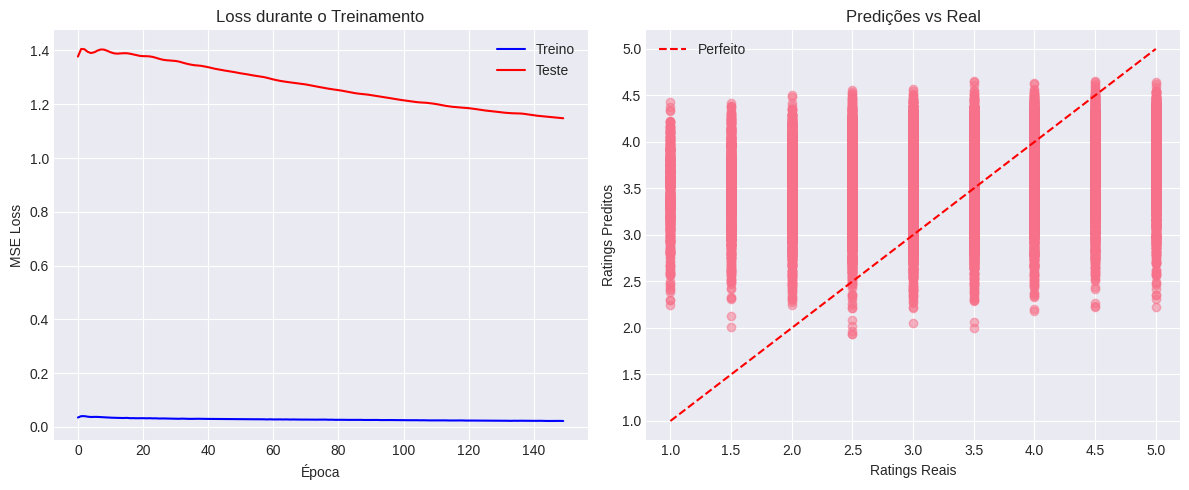

In [53]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Treino', color='blue')
plt.plot(test_losses, label='Teste', color='red')
plt.title('Loss durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(test_ratings.numpy(), final_predictions.numpy(), alpha=0.5)
plt.plot([1, 5], [1, 5], 'r--', label='Perfeito')
plt.xlabel('Ratings Reais')
plt.ylabel('Ratings Preditos')
plt.title('Predições vs Real')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [76]:
class SistemaRecomendacao:
    """Sistema completo de recomendação de produtos agrícolas"""
    
    def __init__(self, model, le_usuario, le_produto, df_nutrientes, df_associacoes, df_producao):
        self.model = model
        self.le_usuario = le_usuario
        self.le_produto = le_produto
        self.df_nutrientes = df_nutrientes
        self.df_associacoes = df_associacoes
        self.df_producao = df_producao
        
    def recomendar_produtos(self, user_id, top_k=10, filtro_nutricional=None, 
                           regiao_preferida=None, considerar_producao=True):
        """
        Gera recomendações personalizadas
        
        Parâmetros:
        - user_id: ID do usuário
        - top_k: Número de recomendações
        - filtro_nutricional: 'baixa_caloria', 'alta_proteina', 'alta_fibra', 'alta_vitamina_c'
        - regiao_preferida: Região do DF para considerar
        - considerar_producao: Se deve considerar dados de produção local
        """
        
        if user_id not in self.le_usuario.classes_:
            return f"Usuário {user_id} não encontrado"
        
        # Obter índice do usuário
        user_idx = self.le_usuario.transform([user_id])[0]
        
        # Gerar predições para todos os produtos
        self.model.eval()
        with torch.no_grad():
            user_tensor = torch.LongTensor([user_idx] * len(self.le_produto.classes_))
            items_tensor = torch.LongTensor(range(len(self.le_produto.classes_)))
            predictions = self.model(user_tensor, items_tensor)
        
        # Criar lista de produtos com scores
        produtos_scores = []
        for i, pred in enumerate(predictions):
            produto = self.le_produto.inverse_transform([i])[0]
            score = pred.item()
            
            # Aplicar filtros nutricionais
            if filtro_nutricional and produto in self.df_nutrientes['nome'].values:
                nutriente = self.df_nutrientes[self.df_nutrientes['nome'] == produto].iloc[0]
                
                if filtro_nutricional == 'baixa_caloria' and nutriente['energia_kcal'] <= 50:
                    score *= 1.2
                elif filtro_nutricional == 'alta_proteina' and nutriente['proteina_g'] >= 2.0:
                    score *= 1.2
                elif filtro_nutricional == 'alta_fibra' and nutriente['fibra_g'] >= 2.5:
                    score *= 1.2
                elif filtro_nutricional == 'alta_vitamina_c' and nutriente['vitamina_c_mg'] >= 20:
                    score *= 1.2
            
            # Considerar produção local
            if considerar_producao and produto in self.df_producao['produto'].values:
                prod_local = self.df_producao[self.df_producao['produto'] == produto]
                if regiao_preferida:
                    prod_regiao = prod_local[prod_local['regiao'] == regiao_preferida]
                    if not prod_regiao.empty:
                        score *= 1.1
                
                # Bonus para produtos com boa produção local
                if prod_local['participacao_df'].max() > 10:
                    score *= 1.05
            
            produtos_scores.append((produto, score))
        
        # Ordenar e retornar top-k
        produtos_scores.sort(key=lambda x: x[1], reverse=True)
        return produtos_scores[:top_k]
    
    def encontrar_fornecedores(self, produto, lat_usuario=-15.7801, long_usuario=-47.9292, 
                              raio_km=50):
        """
        Encontra associações que fornecem determinado produto
        
        Parâmetros:
        - produto: Nome do produto
        - lat_usuario, long_usuario: Coordenadas do usuário (padrão: centro de Brasília)
        - raio_km: Raio de busca em km
        """
        
        fornecedores = []
        
        for _, assoc in self.df_associacoes.iterrows():
            # Verificar se a associação produz o produto
            produtos_assoc = assoc['produtos_limpos']
            
            # Converter string para lista se necessário
            if isinstance(produtos_assoc, str):
                # Remove caracteres extras e converte para lista
                produtos_assoc = produtos_assoc.strip("[]'\"").split("', '")
                produtos_assoc = [p.strip("'\"") for p in produtos_assoc]
            
            if isinstance(produtos_assoc, list) and produto in produtos_assoc:
                
                # Calcular distância
                dist_km = geodesic(
                    (lat_usuario, long_usuario),
                    (assoc['latitude'], assoc['longitude'])
                ).kilometers
                
                if dist_km <= raio_km:
                    fornecedores.append({
                        'nome': assoc['nome'],
                        'distancia_km': round(dist_km, 2),
                        'latitude': assoc['latitude'],
                        'longitude': assoc['longitude'],
                        'regioes': assoc['regioes']
                    })
        
        # Ordenar por distância
        fornecedores.sort(key=lambda x: x['distancia_km'])
        return fornecedores
    
    def obter_info_nutricional(self, produto):
        """Obtém informações nutricionais de um produto"""
        if produto in self.df_nutrientes['nome'].values:
            info = self.df_nutrientes[self.df_nutrientes['nome'] == produto].iloc[0]
            return {
                'energia_kcal': info['energia_kcal'],
                'proteina_g': info['proteina_g'],
                'fibra_g': info['fibra_g'],
                'vitamina_c_mg': info['vitamina_c_mg'],
                'categoria': info['categoria']
            }
        return None

# Inicializar sistema
sistema = SistemaRecomendacao(
    model=model,
    le_usuario=le_usuario,
    le_produto=le_produto,
    df_nutrientes=df_dados_nutricionais,
    df_associacoes=df_associacoes,
    df_producao=df_producao_emater
)